# Tutorial 09

## template fitting mock data test (B mode, parametric CMB)

The `simple likelihood` is designed for pipeline's sanity check:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from afra.tools.bg_models import cambmodel
import seaborn as sns
from dynesty import plotting as dyplot
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap30 = np.random.normal(0.,1.,size=vmap30.shape)*np.sqrt(vmap30)
nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=vmap353.shape)*np.sqrt(vmap353)

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
map30 = hp.smoothing(mapcmb+map30f,fwhm=fwhm[0],verbose=0)+nmap30
map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0)+nmap95
map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0)+nmap150
map353 = hp.smoothing(mapcmb+map353f,fwhm=fwhm[3],verbose=0)+nmap353

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### 1st run with sync model

- mock data frequencies: 95, 150
- template frequency: 30
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw

fg truths:  {'beta_s': -3.0}
cmb truths:  {'r': 0.05}


iter: 3118 | +1000 | bound: 0 | nc: 1 | ncall: 23366 | eff(%): 17.624 | loglstar:   -inf < -0.000 <    inf | logz: -2.753 +/-  0.028 | dlogz:  0.001 >  1.009                                         

CPU times: user 32min 8s, sys: 4.47 s, total: 32min 12s
Wall time: 4min 14s


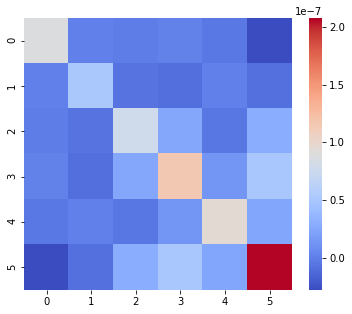

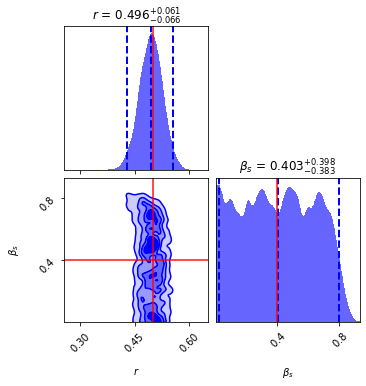

In [2]:
%%time

FREQS = [95.,150.]
NMAP = 2
RESAMP = 30
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(pre_rslt[2],cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30f[1:]

s = syncmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=tmpmap,template_fwhms=None)
s.reset({'beta_s':-3.})

b = cambmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
b.reset({'r': 0.05})

print ('fg truths: ',s.params)
print ('cmb truths: ',b.params)

mock_bp = s.bandpower()+b.bandpower()

KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = s
result = pipeline.analyse(mock_bp,pre_rslt[1],pre_rslt[2],kwargs=KWARGS)

truths = [0.05/0.1,(5.-3.)/5.]
labels = [r'$r$',r'$\beta_s$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

- with HL likelihood

iter: 7065 | +1000 | bound: 6 | nc: 1 | ncall: 42388 | eff(%): 19.027 | loglstar:   -inf < -0.000 <    inf | logz: -6.832 +/-  0.109 | dlogz:  0.001 >  1.009                                         

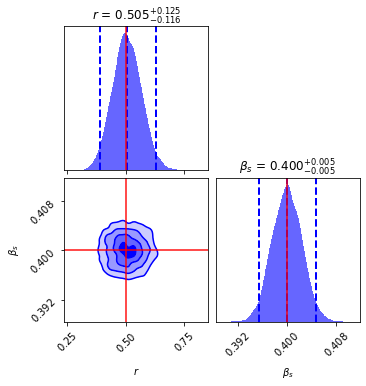

In [3]:
KWARGS = {'nlive':1000}

pipeline.likelihood = 'hl'
result = pipeline.analyse(mock_bp,pre_rslt[1],pre_rslt[2],kwargs=KWARGS)

truths = [0.05/0.1,(5.-3.)/5.]
labels = [r'$r$',r'$\beta_s$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

#### 2nd run with dust model

- mock data frequencies: 95, 150
- template frequency: 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated modified blackbody

fg truths:  {'beta_d': 1.5}
cmb truths:  {'r': 0.05}


iter: 9874 | +1000 | bound: 9 | nc: 1 | ncall: 48396 | eff(%): 22.469 | loglstar:   -inf < -0.001 <    inf | logz: -9.622 +/-  0.130 | dlogz:  0.001 >  1.009                                         

CPU times: user 32min 52s, sys: 5.76 s, total: 32min 58s
Wall time: 4min 32s


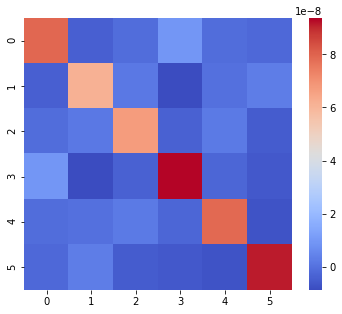

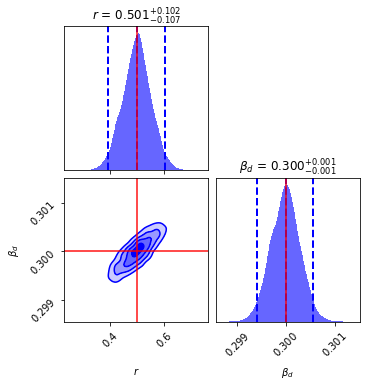

In [4]:
%%time

FREQS = [95.,150.]
NMAP = 2
RESAMP = 30
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(pre_rslt[2],cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[353] = map353f[1:]

d = dustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=tmpmap,template_fwhms=None)
d.reset({'beta_d':1.5})

b = cambmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
b.reset({'r':0.05})
    
print ('fg truths: ',d.params)
print ('cmb truths: ',b.params)

mock_bp = d.bandpower()+b.bandpower()

KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = d
result = pipeline.analyse(mock_bp,pre_rslt[1],pre_rslt[2],kwargs=KWARGS)

truths = [0.05/0.1,1.5/5.]
labels = [r'$r$',r'$\beta_d$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

- with HL likelihood

iter: 7178 | +1000 | bound: 5 | nc: 1 | ncall: 42383 | eff(%): 19.295 | loglstar:   -inf < -0.000 <    inf | logz: -6.948 +/-  0.110 | dlogz:  0.001 >  1.009                                         

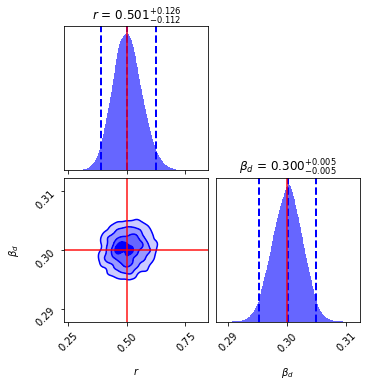

In [5]:
KWARGS = {'nlive':1000}

pipeline.likelihood = 'hl'
result = pipeline.analyse(mock_bp,pre_rslt[1],pre_rslt[2],kwargs=KWARGS)

truths = [0.05/0.1,1.5/5.]
labels = [r'$r$',r'$\beta_d$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

#### 3rd run with sync+dust model

- mock data frequencies: 95, 150
- template frequency: 30, 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw and templated modified blackbody

fg truths:  {'beta_s': -3.0, 'beta_d': 1.5, 'rho': 0.1}
cmb truths:  {'r': 0.05}


iter: 10719 | +1000 | bound: 16 | nc: 1 | ncall: 58984 | eff(%): 19.868 | loglstar:   -inf < -0.008 <    inf | logz: -10.532 +/-  0.141 | dlogz:  0.001 >  1.009                                      

CPU times: user 43min 48s, sys: 8.08 s, total: 43min 56s
Wall time: 6min 8s


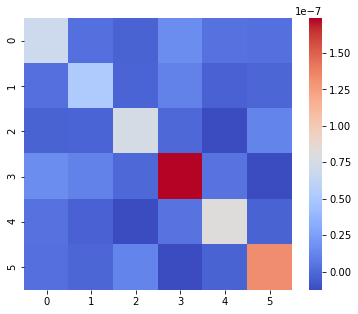

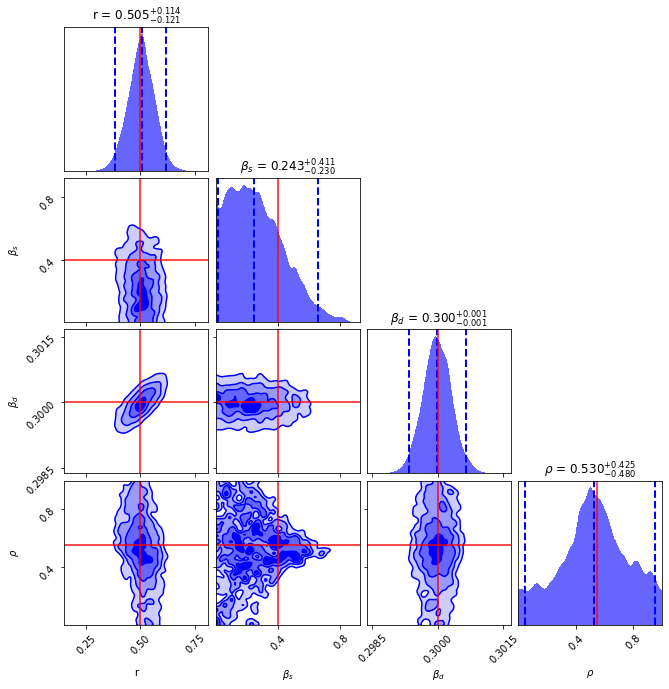

In [6]:
%%time

FREQS = [95.,150.]
NMAP = 2
RESAMP = 40
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(pre_rslt[2],cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30f[1:]
tmpmap[353] = map353f[1:]

c = syncdustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
                  templates=tmpmap,template_fwhms=None)
c.reset({'beta_s':-3.})
c.reset({'beta_d':1.5})
c.reset({'rho':0.1})

b = cambmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
b.reset({'r':0.05})
    
print ('fg truths: ',c.params)
print ('cmb truths: ',b.params)

mock_bp = c.bandpower()+b.bandpower()

KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = c
result = pipeline.analyse(mock_bp,pre_rslt[1],pre_rslt[2],kwargs=KWARGS)

truths = [0.05/0.1,(5.-3.)/5.,1.5/5.,1.1/2.]
labels = [r'r',r'$\beta_s$',r'$\beta_d$',r'$\rho$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

- with HL likelihood

iter: 8105 | +1000 | bound: 11 | nc: 1 | ncall: 51869 | eff(%): 17.554 | loglstar:   -inf < -0.008 <    inf | logz: -7.920 +/-  0.122 | dlogz:  0.001 >  1.009                                        

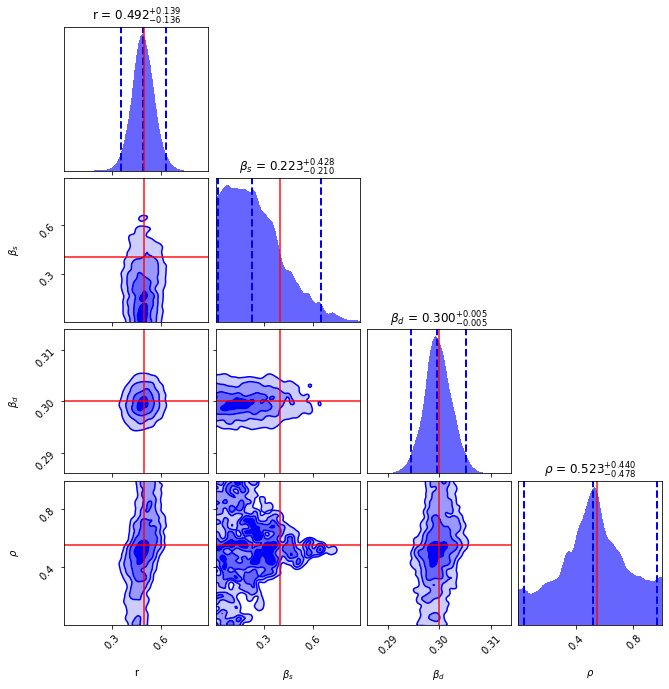

In [7]:
KWARGS = {'nlive':1000}

pipeline.likelihood = 'hl'
result = pipeline.analyse(mock_bp,pre_rslt[1],pre_rslt[2],kwargs=KWARGS)

truths = [0.05/0.1,(5.-3.)/5.,1.5/5.,1.1/2.]
labels = [r'r',r'$\beta_s$',r'$\beta_d$',r'$\rho$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])